In [48]:
import numpy as np
import wave
from scipy.io import wavfile
import matplotlib.pyplot as plt
import os
from scipy.io.wavfile import write

In [97]:
path = "./audio/"

def read_wav_file(filename):
    with wave.open(filename, 'rb') as wf:
        params = wf.getparams()
        num_channels, sampwidth, framerate, num_frames = params[:4]
        frames = wf.readframes(num_frames)
        waveform = np.frombuffer(frames, dtype=np.int16)
    return waveform, params

def read_wav_file_scipy(filename):
    framerate, waveform = wavfile.read(filename)
    return waveform, framerate

def plot_waveform(waveform, framerate):
    # Create a time array in seconds
    time_array = np.arange(0, len(waveform)) / framerate
    plt.figure(figsize=(15, 5))
    plt.plot(time_array, waveform, label="Waveform")
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Waveform')
    plt.legend()
    plt.show()

def read_files_in_dir(directory):
    filenames = os.listdir(directory)
    return filenames


def pick_5_samples(arrays):
    instruments = []
    for array in arrays:
        pick = np.random.choice(array, 1)
        instruments.append(pick)
    return instruments

#read the filenames, and add their data to 5 lists
def add_waveform_to_list(filenames):
    waveforms = []
    for filename in filenames:
        waveform, params = read_wav_file_scipy(path + filename[0])
        waveforms.append(waveform)
    return waveforms
        
#Fast fourier transform
def fft_h(data, sample_rate):
    n = len(data)
    fft_data = np.fft.fft(data)
    freq = np.fft.fftfreq(n, d=1/sample_rate)
    return freq[:n//2], np.abs(fft_data[:n//2])

def combine_waveforms(waveforms):
    normalization = 1 / len(waveforms)
    out = np.zeros_like(waveforms[0], dtype=np.float32)
    for w in waveforms:
        out += w.astype(np.float32) * normalization
    return out # note, this retuns a float32 array - it is needed to convert this to int16 before saving it to a wav file


def waveform_to_wavfile(waveform, name_string, sample_rate = 16000):
    write(name_string, sample_rate, waveform.astype(np.int16))

#Sorting the files in directory

filenames = read_files_in_dir(path)
#pianos = [filename for filename in filenames if "piano" in filename] #empty
bass = [filename for filename in filenames if "bass" in filename]
guitar = [filename for filename in filenames if "guitar" in filename]
#drum = [filename for filename in filenames if "drum" in filename] #empty
flutes = [filename for filename in filenames if "flute" in filename]
keyboards = [filename for filename in filenames if "keyboard" in filename]


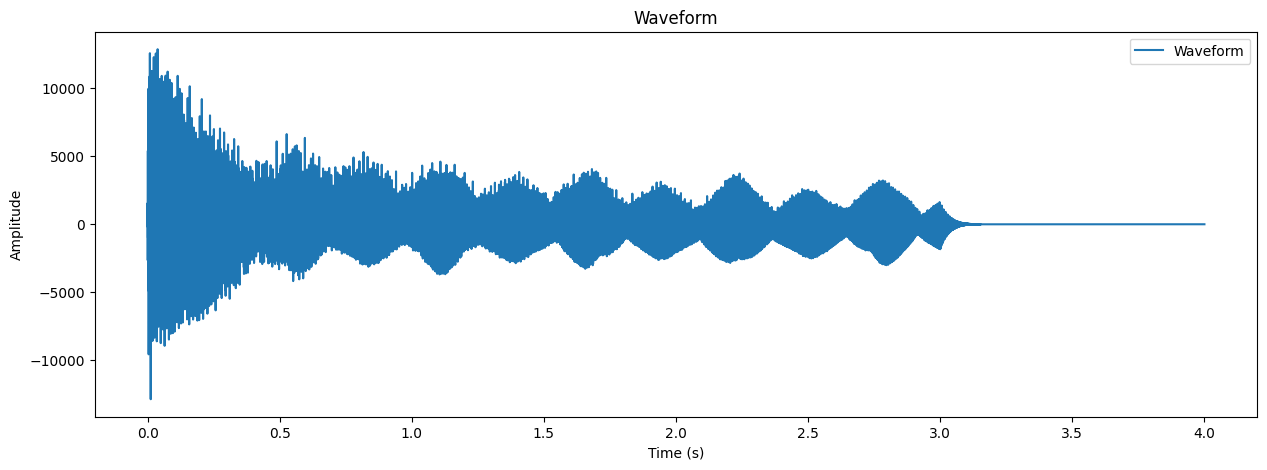

In [98]:
#Pick a random sample of each instrument
waveforms = add_waveform_to_list(pick_5_samples([bass, guitar, flutes, keyboards]))

#Combine the waveforms
combined_waveform = combine_waveforms(waveforms)

#Save the combined waveform to a wav file
waveform_to_wavfile(combined_waveform, "combo.wav", 16000)

#Plot the combined waveform
plot_waveform(combined_waveform, 16000)